# Attention Weight 추출 및 비교 분석 (최종 수정)

### 1. 초기 설정 및 라이브러리 임포트

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
import warnings
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Multiply, Add, Activation, Concatenate, LayerNormalization, Dropout, MultiHeadAttention
from deepFilter.dl_models import Transformer_DAE, Dual_FreqDAE, FANLayer, Conv1DTranspose, TFPositionalEncoding1D, frequency_branch
from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier

warnings.filterwarnings('ignore')

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU 설정 완료: {len(gpus)}개 GPU")
    except RuntimeError as e:
        print(f"⚠️ GPU 설정 실패: {e}")
else:
    print("❌ GPU 없음, CPU 사용")

✅ GPU 설정 완료: 2개 GPU


### 2. Attention Score를 출력하는 모델 재정의 (Functional API 활용)

In [42]:
def Transformer_DAE_with_attention(signal_size=512, head_size=64, num_heads=2, ff_dim=64, num_transformer_blocks=2, dropout=0):
    input_tensor = Input(shape=(signal_size, 1), name='input')
    ks = 13
    x0 = Conv1D(filters=16, kernel_size=ks, activation='linear', strides=2, padding='same')(input_tensor)
    x0 = Activation('sigmoid')(x0)
    x0_ = Conv1D(filters=16, kernel_size=ks, activation=None, strides=2, padding='same')(input_tensor)
    xmul0 = Multiply()([x0, x0_])
    xmul0 = BatchNormalization()(xmul0)
    x1 = Conv1D(filters=32, kernel_size=ks, activation='linear', strides=2, padding='same')(xmul0)
    x1 = Activation('sigmoid')(x1)
    x1_ = Conv1D(filters=32, kernel_size=ks, activation=None, strides=2, padding='same')(xmul0)
    xmul1 = Multiply()([x1, x1_])
    xmul1 = BatchNormalization()(xmul1)
    x2 = Conv1D(filters=64, kernel_size=ks, activation='linear', strides=2, padding='same')(xmul1)
    x2 = Activation('sigmoid')(x2)
    x2_ = Conv1D(filters=64, kernel_size=ks, activation='elu', strides=2, padding='same')(xmul1)
    xmul2 = Multiply()([x2, x2_])
    xmul2 = BatchNormalization()(xmul2)
    position_embed = TFPositionalEncoding1D(signal_size)
    x3 = xmul2 + position_embed(xmul2)

    attention_outputs = []
    for i in range(num_transformer_blocks):
        x_norm = LayerNormalization(epsilon=1e-6)(x3)
        mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout, name=f'mha_block_{i}')
        x_att, scores = mha_layer(x_norm, x_norm, return_attention_scores=True)
        attention_outputs.append(scores) # 점수 저장
        x_att = Dropout(dropout)(x_att)
        x3 = Add()([x3, x_att])
        x_ff = LayerNormalization(epsilon=1e-6)(x3)
        x_ff = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x_ff)
        x_ff = Dropout(dropout)(x_ff)
        x_ff = Conv1D(filters=x3.shape[-1], kernel_size=1)(x_ff)
        x3 = Add()([x3, x_ff])

    x4 = x3
    x5 = Conv1DTranspose(input_tensor=x4, filters=64, kernel_size=ks, activation='elu', strides=1, padding='same')
    x5 = Add()([x5, xmul2])
    x5 = BatchNormalization()(x5)
    x6 = Conv1DTranspose(input_tensor=x5, filters=32, kernel_size=ks, activation='elu', strides=2, padding='same')
    x6 = Add()([x6, xmul1])
    x6 = BatchNormalization()(x6)
    x7 = Conv1DTranspose(input_tensor=x6, filters=16, kernel_size=ks, activation='elu', strides=2, padding='same')
    x7 = Add()([x7, xmul0])
    x8 = BatchNormalization()(x7)
    predictions = Conv1DTranspose(input_tensor=x8, filters=1, kernel_size=ks, activation='linear', strides=2, padding='same')
    
    model = Model(inputs=input_tensor, outputs=[predictions] + attention_outputs)
    return model

def Dual_FreqDAE_with_attention(signal_size=512, head_size=64, num_heads=8, hidden_dim=2048, ff_dim=64, num_transformer_blocks=8, dropout=0):
    time_input = Input(shape=(signal_size, 1), name='time_input')
    freq_input = Input(shape=(signal_size, 1), name='freq_input')
    ks = 13
    x0 = Conv1D(filters=16, kernel_size=ks, activation='linear', strides=2, padding='same')(time_input)
    x0 = Activation('sigmoid')(x0)
    x0_ = Conv1D(filters=16, kernel_size=ks, activation=None, strides=2, padding='same')(time_input)
    xmul0 = Multiply()([x0, x0_])
    xmul0 = BatchNormalization()(xmul0)
    x1 = Conv1D(filters=32, kernel_size=ks, activation='linear', strides=2, padding='same')(xmul0)
    x1 = Activation('sigmoid')(x1)
    x1_ = Conv1D(filters=32, kernel_size=ks, activation=None, strides=2, padding='same')(xmul0)
    xmul1 = Multiply()([x1, x1_])
    xmul1 = BatchNormalization()(xmul1)
    x2 = Conv1D(filters=64, kernel_size=ks, activation='linear', strides=2, padding='same')(xmul1)
    x2 = Activation('sigmoid')(x2)
    x2_ = Conv1D(filters=64, kernel_size=ks, activation='elu', strides=2, padding='same')(xmul1)
    xmul2 = Multiply()([x2, x2_])
    xmul2 = BatchNormalization()(xmul2)
    f2 = frequency_branch(freq_input, 16, 13)
    combined = Concatenate()([xmul2, f2])
    position_embed = TFPositionalEncoding1D(signal_size)
    x3 = combined + position_embed(combined)

    attention_outputs = []
    for i in range(num_transformer_blocks):
        x_norm = LayerNormalization(epsilon=1e-6)(x3)
        mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout, name=f'mha_block_{i}')
        x_att, scores = mha_layer(x_norm, x_norm, return_attention_scores=True)
        attention_outputs.append(scores)
        x_att = Dropout(dropout)(x_att)
        x3 = Add()([x3, x_att])
        x_ff = LayerNormalization(epsilon=1e-6)(x3)
        x_ff = FANLayer(output_dim=x3.shape[-1]*4, p_ratio=0.25, activation="gelu", gated=False)(x_ff)
        x_ff = FANLayer(output_dim=x3.shape[-1], p_ratio=0.25, activation="gelu", gated=False)(x_ff)
        x_ff = Dropout(dropout)(x_ff)
        x3 = Add()([x3, x_ff])

    x4 = x3
    x5 = Conv1DTranspose(input_tensor=x4, filters=64, kernel_size=ks, activation='elu', strides=1, padding='same')
    x5 = Add()([x5, xmul2])
    x5 = BatchNormalization()(x5)
    x6 = Conv1DTranspose(input_tensor=x5, filters=32, kernel_size=ks, activation='elu', strides=2, padding='same')
    x6 = Add()([x6, xmul1])
    x6 = BatchNormalization()(x6)
    x7 = Conv1DTranspose(input_tensor=x6, filters=16, kernel_size=ks, activation='elu', strides=2, padding='same')
    x7 = Add()([x7, xmul0])
    x8 = BatchNormalization()(x7)
    predictions = Conv1DTranspose(input_tensor=x8, filters=1, kernel_size=ks, activation='linear', strides=2, padding='same')
    
    model = Model(inputs=[time_input, freq_input], outputs=[predictions] + attention_outputs)
    return model

### 3. 데이터 준비 및 Attention Matrix 추출

In [43]:
# 데이터 준비
print("데이터 준비 중...")
Dataset, _, _ = Data_Preparation_with_Fourier(samples=512, fs=360)
_, _, X_test, _, _, _, F_test_x, _ = Dataset
X_test_sample = X_test[:1]
F_test_sample = F_test_x[:1]
print("✅ 데이터 준비 완료!")

# Transformer_DAE Attention 추출
print("1️⃣ Transformer_DAE Attention 추출 중...")
tf.keras.backend.clear_session()
original_transformer_model = Transformer_DAE(signal_size=512, head_size=64, num_heads=2, ff_dim=64, num_transformer_blocks=2)
transformer_weights_path = '0221_FIXED/Transformer_DAE_weights.best.weights.h5'
original_transformer_model.load_weights(transformer_weights_path)
attention_transformer_model = Transformer_DAE_with_attention(signal_size=512, head_size=64, num_heads=2, ff_dim=64, num_transformer_blocks=2)
for layer in original_transformer_model.layers:
    try:
        attention_transformer_model.get_layer(layer.name).set_weights(layer.get_weights())
    except (ValueError, KeyError) as e:
        print(f"⚠️ {layer.name} 레이어의 가중치를 복사하는 중 오류 발생: {e}")

transformer_outputs = attention_transformer_model.predict(X_test_sample)
attention_matrices_transformer = transformer_outputs[1:]
print("✅ Transformer_DAE 추출 완료!")

# Dual_FreqDAE Attention 추출
print("2️⃣ Dual_FreqDAE (FAN) Attention 추출 중...")
tf.keras.backend.clear_session()
original_dual_model = Dual_FreqDAE(signal_size=512, head_size=64, num_heads=8, hidden_dim=2048, ff_dim=64, num_transformer_blocks=8)
dual_weights_path = '0221_FIXED/Dual_FreqDAE_weights.best.weights.h5'
original_dual_model.load_weights(dual_weights_path)
attention_dual_model = Dual_FreqDAE_with_attention(signal_size=512, head_size=64, num_heads=8, hidden_dim=2048, ff_dim=64, num_transformer_blocks=8)
for layer in original_dual_model.layers:
    try:
        attention_dual_model.get_layer(layer.name).set_weights(layer.get_weights())
    except (ValueError, KeyError) as e:
        print(f"⚠️ {layer.name} 레이어의 가중치를 복사하는 중 오류 발생: {e}")

dual_outputs = attention_dual_model.predict([X_test_sample, F_test_sample])
attention_matrices_dual = dual_outputs[1:]
print("✅ Dual_FreqDAE (FAN) 추출 완료!")

데이터 준비 중...
Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 650000 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in tr

2025-08-08 06:55:28.968343: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_81', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
✅ Dual_FreqDAE (FAN) 추출 완료!


### 4. 비교 분석 및 시각화

📊 === 비교 분석: Transformer_DAE vs Dual_FreqDAE (FAN) ===


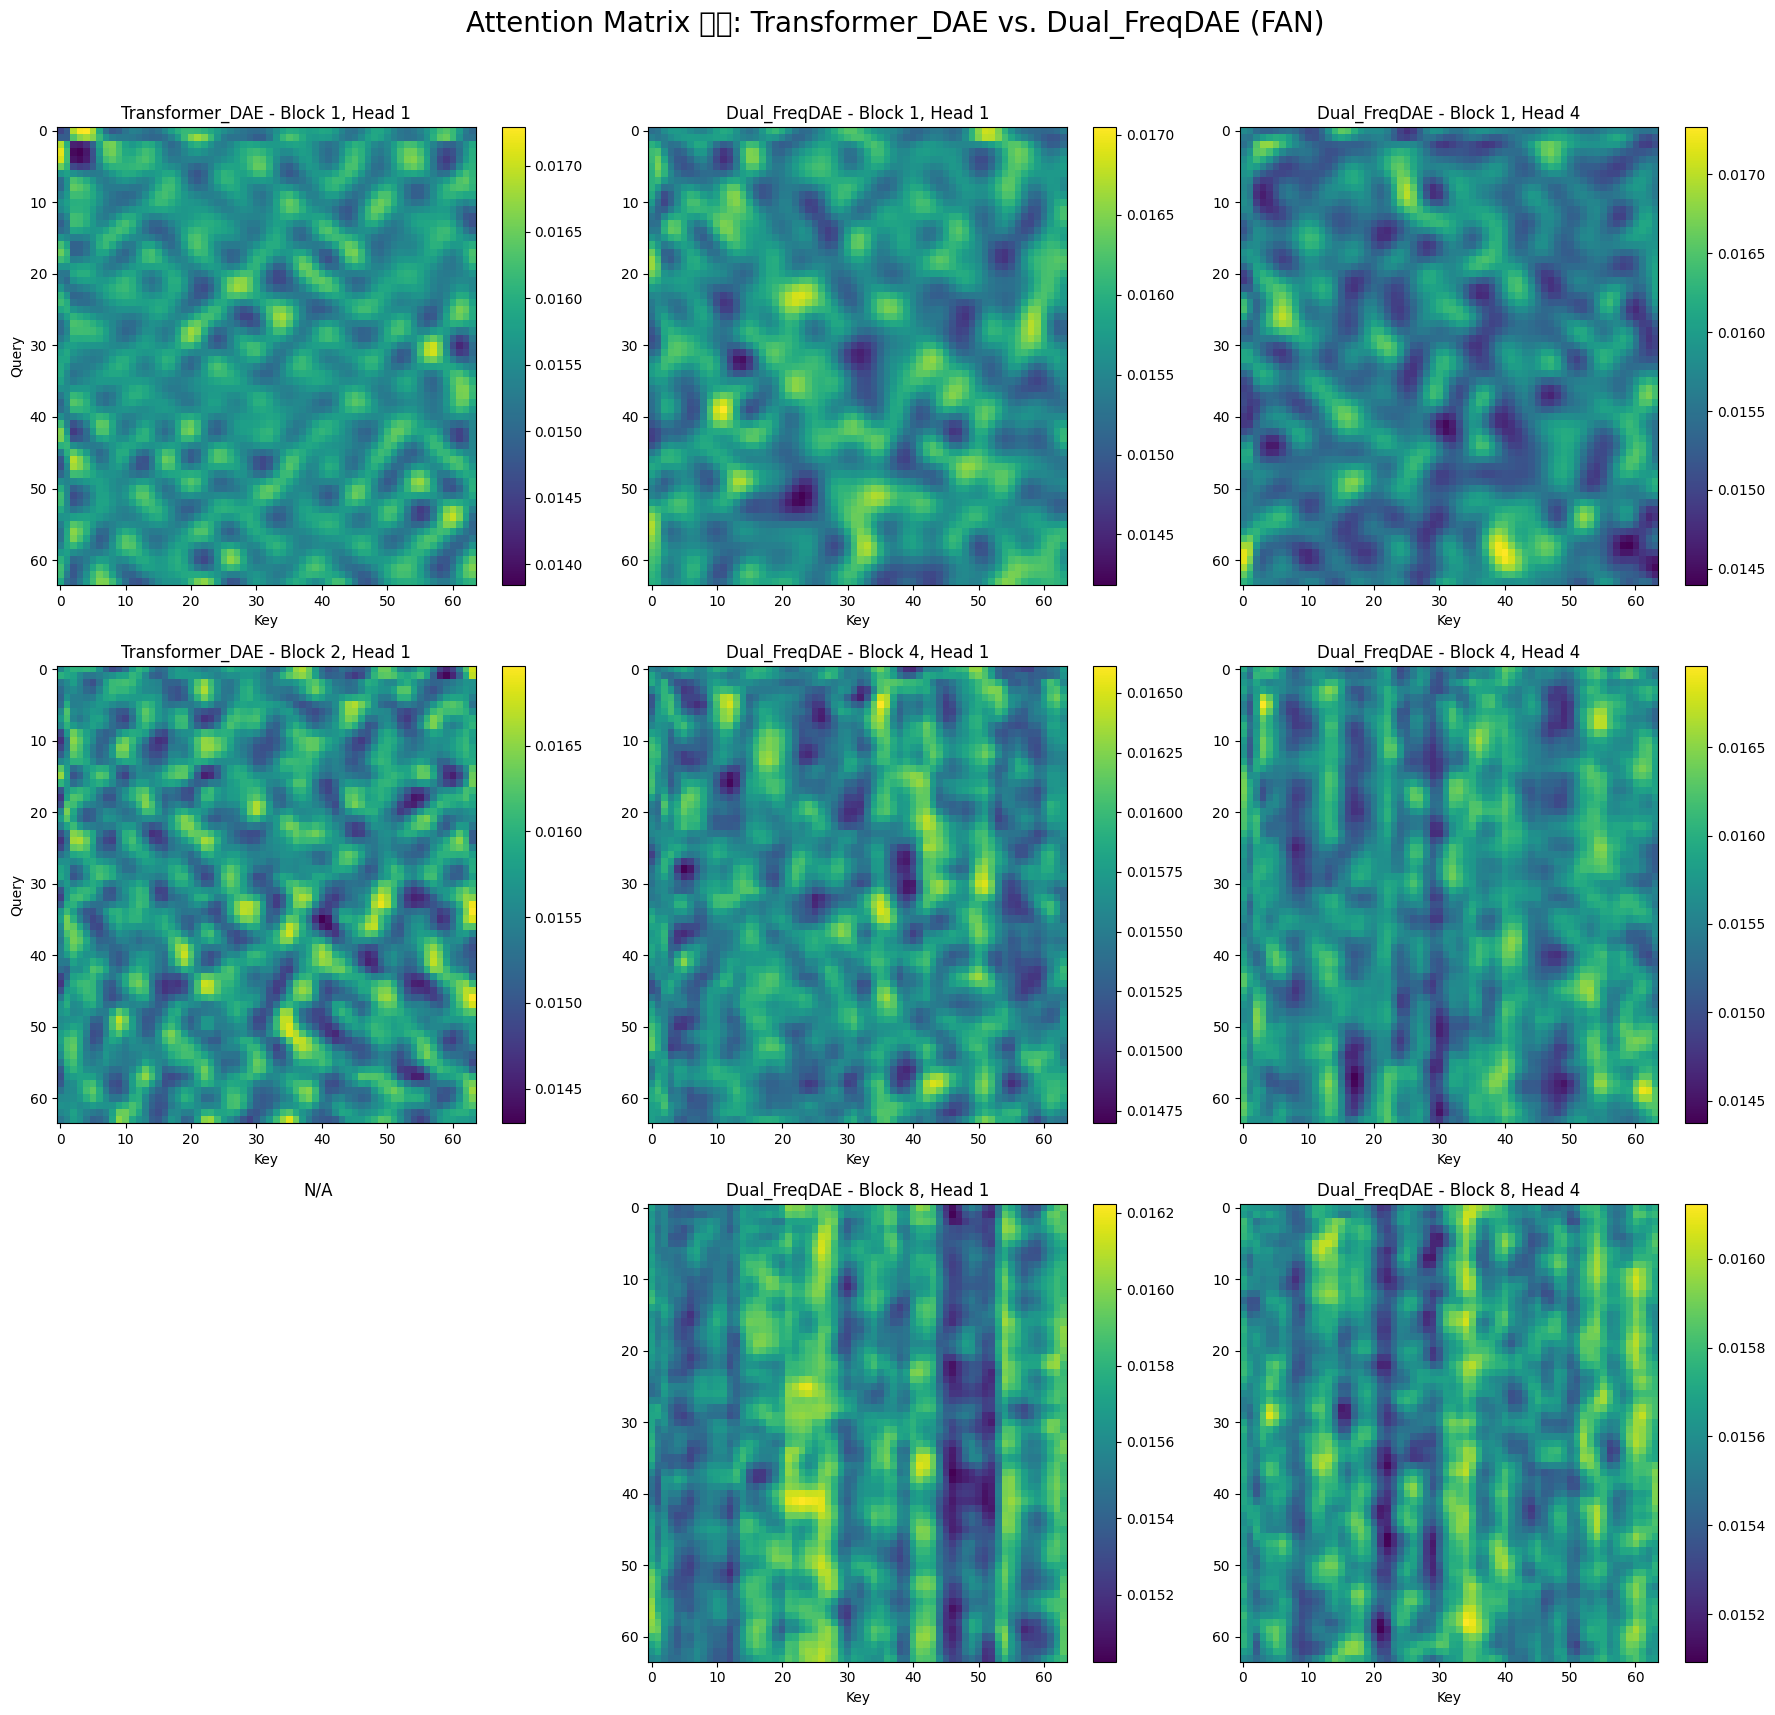

🔬 === 정량 분석: 평균 Attention Entropy ===
Transformer_DAE: 4.1587
Dual_FreqDAE (FAN): 4.1589
🤔 가설 불일치: Transformer_DAE 모델이 더 집중된 Attention을 보여줍니다.


In [44]:
print("📊 === 비교 분석: Transformer_DAE vs Dual_FreqDAE (FAN) ===")
blocks_to_compare = [0, 3, 7]
heads_to_compare = [0, 3]
fig, axes = plt.subplots(len(blocks_to_compare), 3, figsize=(18, 6 * len(blocks_to_compare)), squeeze=False)
fig.suptitle('Attention Matrix 비교: Transformer_DAE vs. Dual_FreqDAE (FAN)', fontsize=20)
for i, block_idx in enumerate(blocks_to_compare):
    if i < len(attention_matrices_transformer):
        ax1 = axes[i, 0]
        im1 = ax1.imshow(attention_matrices_transformer[i][0, 0, :, :], cmap='viridis', aspect='auto')
        ax1.set_title(f'Transformer_DAE - Block {i+1}, Head 1')
        ax1.set_ylabel('Query')
        fig.colorbar(im1, ax=ax1)
    else:
        axes[i, 0].axis('off')
        axes[i, 0].set_title('N/A')
    ax2 = axes[i, 1]
    im2 = ax2.imshow(attention_matrices_dual[block_idx][0, heads_to_compare[0], :, :], cmap='viridis', aspect='auto')
    ax2.set_title(f'Dual_FreqDAE - Block {block_idx+1}, Head {heads_to_compare[0]+1}')
    fig.colorbar(im2, ax=ax2)
    ax3 = axes[i, 2]
    im3 = ax3.imshow(attention_matrices_dual[block_idx][0, heads_to_compare[1], :, :], cmap='viridis', aspect='auto')
    ax3.set_title(f'Dual_FreqDAE - Block {block_idx+1}, Head {heads_to_compare[1]+1}')
    fig.colorbar(im3, ax=ax3)
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlabel('Key')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('attention_comparison.png')
plt.show()
def calculate_avg_entropy(attention_matrices):
    all_entropies = []
    for block in attention_matrices:
        mean_head_attention = np.mean(block, axis=1)[0]
        for i in range(mean_head_attention.shape[0]):
            all_entropies.append(entropy(mean_head_attention[i]))
    return np.mean(all_entropies)
entropy_transformer = calculate_avg_entropy(attention_matrices_transformer)
entropy_dual = calculate_avg_entropy(attention_matrices_dual)
print("🔬 === 정량 분석: 평균 Attention Entropy ===")
print(f"Transformer_DAE: {entropy_transformer:.4f}")
print(f"Dual_FreqDAE (FAN): {entropy_dual:.4f}")
if entropy_dual < entropy_transformer:
    print("✅ 가설 검증: Dual_FreqDAE (FAN) 모델이 더 낮은 엔트로피, 즉 더 집중된 Attention을 보여줍니다.")
else:
    print("🤔 가설 불일치: Transformer_DAE 모델이 더 집중된 Attention을 보여줍니다.")

  자세한 설명 (Detailed Explanation)


   1. 무엇을 하는 노트북인가? (What does the notebook do?)
       * Attention Weight 추출: 딥러닝 모델, 특히 트랜스포머(Transformer) 기반 모델들은 입력 데이터의 여러 부분에 각기 다른 "가중치"를 부여하여 처리합니다. 이를 "어텐션(Attention)"이라고 부릅니다. 이 노트북은
         이미 학습된 두 모델(Transformer_DAE, Dual_FreqDAE)을 가져와서, 특정 데이터 샘플을 처리할 때의 어텐션 가중치(Attention Weight)를 추출합니다.
       * 두 모델 비교: 주된 목적은 두 모델의 어텐션 방식을 비교하는 것입니다.
           * Transformer_DAE: 일반적인 트랜스포머 기반의 노이즈 제거 모델입니다.
           * Dual_FreqDAE: 시간(Time) 정보와 주파수(Frequency) 정보를 함께 사용하는, 더 발전된 모델로 보입니다.
       * 가설 검증: 코드를 보면 "Dual_FreqDAE 모델이 더 집중된 Attention을 보여줄 것이다"라는 가설을 세우고, 이를 시각적(그림) 및 정량적(엔트로피 계산)으로 검증하려 합니다. "집중된 어텐션"은 모델이 불필요한
         정보는 무시하고 중요한 부분에만 집중한다는 의미이며, 보통 더 좋은 성능과 효율성을 의미합니다.


   2. 그림(`attention_comparison.png`)의 의미는 무엇인가? (What does the figure mean?)
       * 어텐션 시각화: 이 그림은 위에서 추출한 어텐션 가중치를 히트맵(Heatmap) 형태로 시각화한 것입니다.
       * 해석 방법:
           * 각 행렬의 밝은 부분은 모델이 해당 부분을 "더 중요하게" 또는 "더 많이 주목하고 있다"는 뜻입니다.
           * 두 모델의 히트맵을 나란히 놓고 비교함으로써, 어느 모델의 어텐션이 더 명확하고 집중되어 있는지 한눈에 파악할 수 있습니다.
           * 만약 Dual_FreqDAE의 히트맵이 더 선명하고 특정 패턴(예: 대각선)을 보인다면, 이는 모델이 신호의 특정 관계를 더 잘 학습하여 체계적으로 처리하고 있다는 증거가 될 수 있습니다.
       * 엔트로피(Entropy) 분석: 그림 아래의 엔트로피 계산은 이러한 시각적 분석을 숫자로 뒷받침합니다. 엔트로피가 낮을수록 어텐션이 분산되지 않고 특정 부분에 더 집중되어 있다는 의미입니다.

  결론 (Conclusion)


  결론적으로, 이 노트북과 그림은 "우리가 만든 `Dual_FreqDAE` 모델이 기존 `Transformer_DAE` 모델보다 ECG 신호의 중요한 특징을 더 잘 포착하여 효율적으로 노이즈를 제거한다"는 것을 증명하기 위한 분석 자료입니다.
  단순히 성능 점수(예: SNR 개선)만 비교하는 것을 넘어, 모델이 어떻게 더 잘 작동하는지 그 내부 메커니즘을 깊이 있게 들여다보는 과정이라고 할 수 있습니다.